# Telecom Churn Prediction - Assignment Notebook

**Author:** Michael Thomas & Supriyo Roy

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [2]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# #INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
# #(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("train.csv", index_col=None)
unseen = pd.read_csv("test.csv", index_col=None)
sample = pd.read_csv("sample.csv", index_col=None)
data_dict = pd.read_csv("data_dictionary.csv", index_col=None)


print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [4]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

# 2. Create X, y and then Train test split

Lets create X and y datasets and drop any column with only 1 unique value

In [5]:
data['circle_id'].unique()

array([109])

In [6]:
X = data.drop(['circle_id'], axis='columns').iloc[:, :-1]
y = data.iloc[:, -1]

X.shape, y.shape


((69999, 170), (69999,))

In [7]:
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
69994    0
69995    0
69996    0
69997    0
69998    0
Name: churn_probability, Length: 69999, dtype: int64


In [8]:
print(X.columns)

Index(['id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7', 'arpu_8',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
      dtype='object', length=170)


In [9]:
X.head()

id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
0   0             0.0             0.0             0.0            6/30/2014   
1   1             0.0             0.0             0.0            6/30/2014   
2   2             0.0             0.0             0.0            6/30/2014   
3   3             0.0             0.0             0.0            6/30/2014   
4   4             0.0             0.0             0.0            6/30/2014   

  last_date_of_month_7 last_date_of_month_8   arpu_6   arpu_7   arpu_8  ...  \
0            7/31/2014            8/31/2014   31.277   87.009    7.527  ...   
1            7/31/2014            8/31/2014    0.000  122.787   42.953  ...   
2            7/31/2014            8/31/2014   60.806  103.176    0.000  ...   
3            7/31/2014            8/31/2014  156.362  205.260  111.095  ...   
4            7/31/2014            8/31/2014  240.708  128.191  101.565  ...   

   sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0            0            0            0        NaN        NaN        NaN   
1            0            0            0        NaN        1.0        NaN   
2            0            0            0        NaN        NaN        NaN   
3            0            0            0        NaN        NaN        NaN   
4            0            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0  1958         0.0         0.0         0.0  
1   710         0.0         0.0         0.0  
2   882         0.0         0.0         0.0  
3   982         0.0         0.0         0.0  
4   647         0.0         0.0         0.0  

[5 rows x 170 columns]

Removing the date columns


In [10]:
# Dropping date columns, which don't appear to contribute to the results and are not numerical variables
columns_to_drop = [
    'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
    'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
    'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'
]

# Drop the specified columns from `data`
X = data.drop(columns=columns_to_drop, axis='columns').iloc[:, :-1]
y = data.iloc[:, -1]

X.shape, y.shape


((69999, 162), (69999,))

In [11]:
# Dropping columns that only have a single value, and does not contribute to the results
threshold = 1

# Find columns with unique value counts below the threshold
few_unique_cols = {col: X[col].nunique() for col in X.columns if X[col].nunique() <= threshold}

# Display the columns and their unique counts
print(few_unique_cols)



{'circle_id': 1, 'loc_og_t2o_mou': 1, 'std_og_t2o_mou': 1, 'loc_ic_t2o_mou': 1, 'std_og_t2c_mou_6': 1, 'std_og_t2c_mou_7': 1, 'std_og_t2c_mou_8': 1, 'std_ic_t2o_mou_6': 1, 'std_ic_t2o_mou_7': 1, 'std_ic_t2o_mou_8': 1}


In [12]:
# Filter out columns with only one unique value
single_value_columns = [col for col in X.columns if X[col].nunique() == 1]

# Drop these columns from the DataFrame
X = X.drop(columns=single_value_columns)

# Display the shape of the updated DataFrame to confirm columns were dropped
X.shape


(69999, 152)

<Axes: >

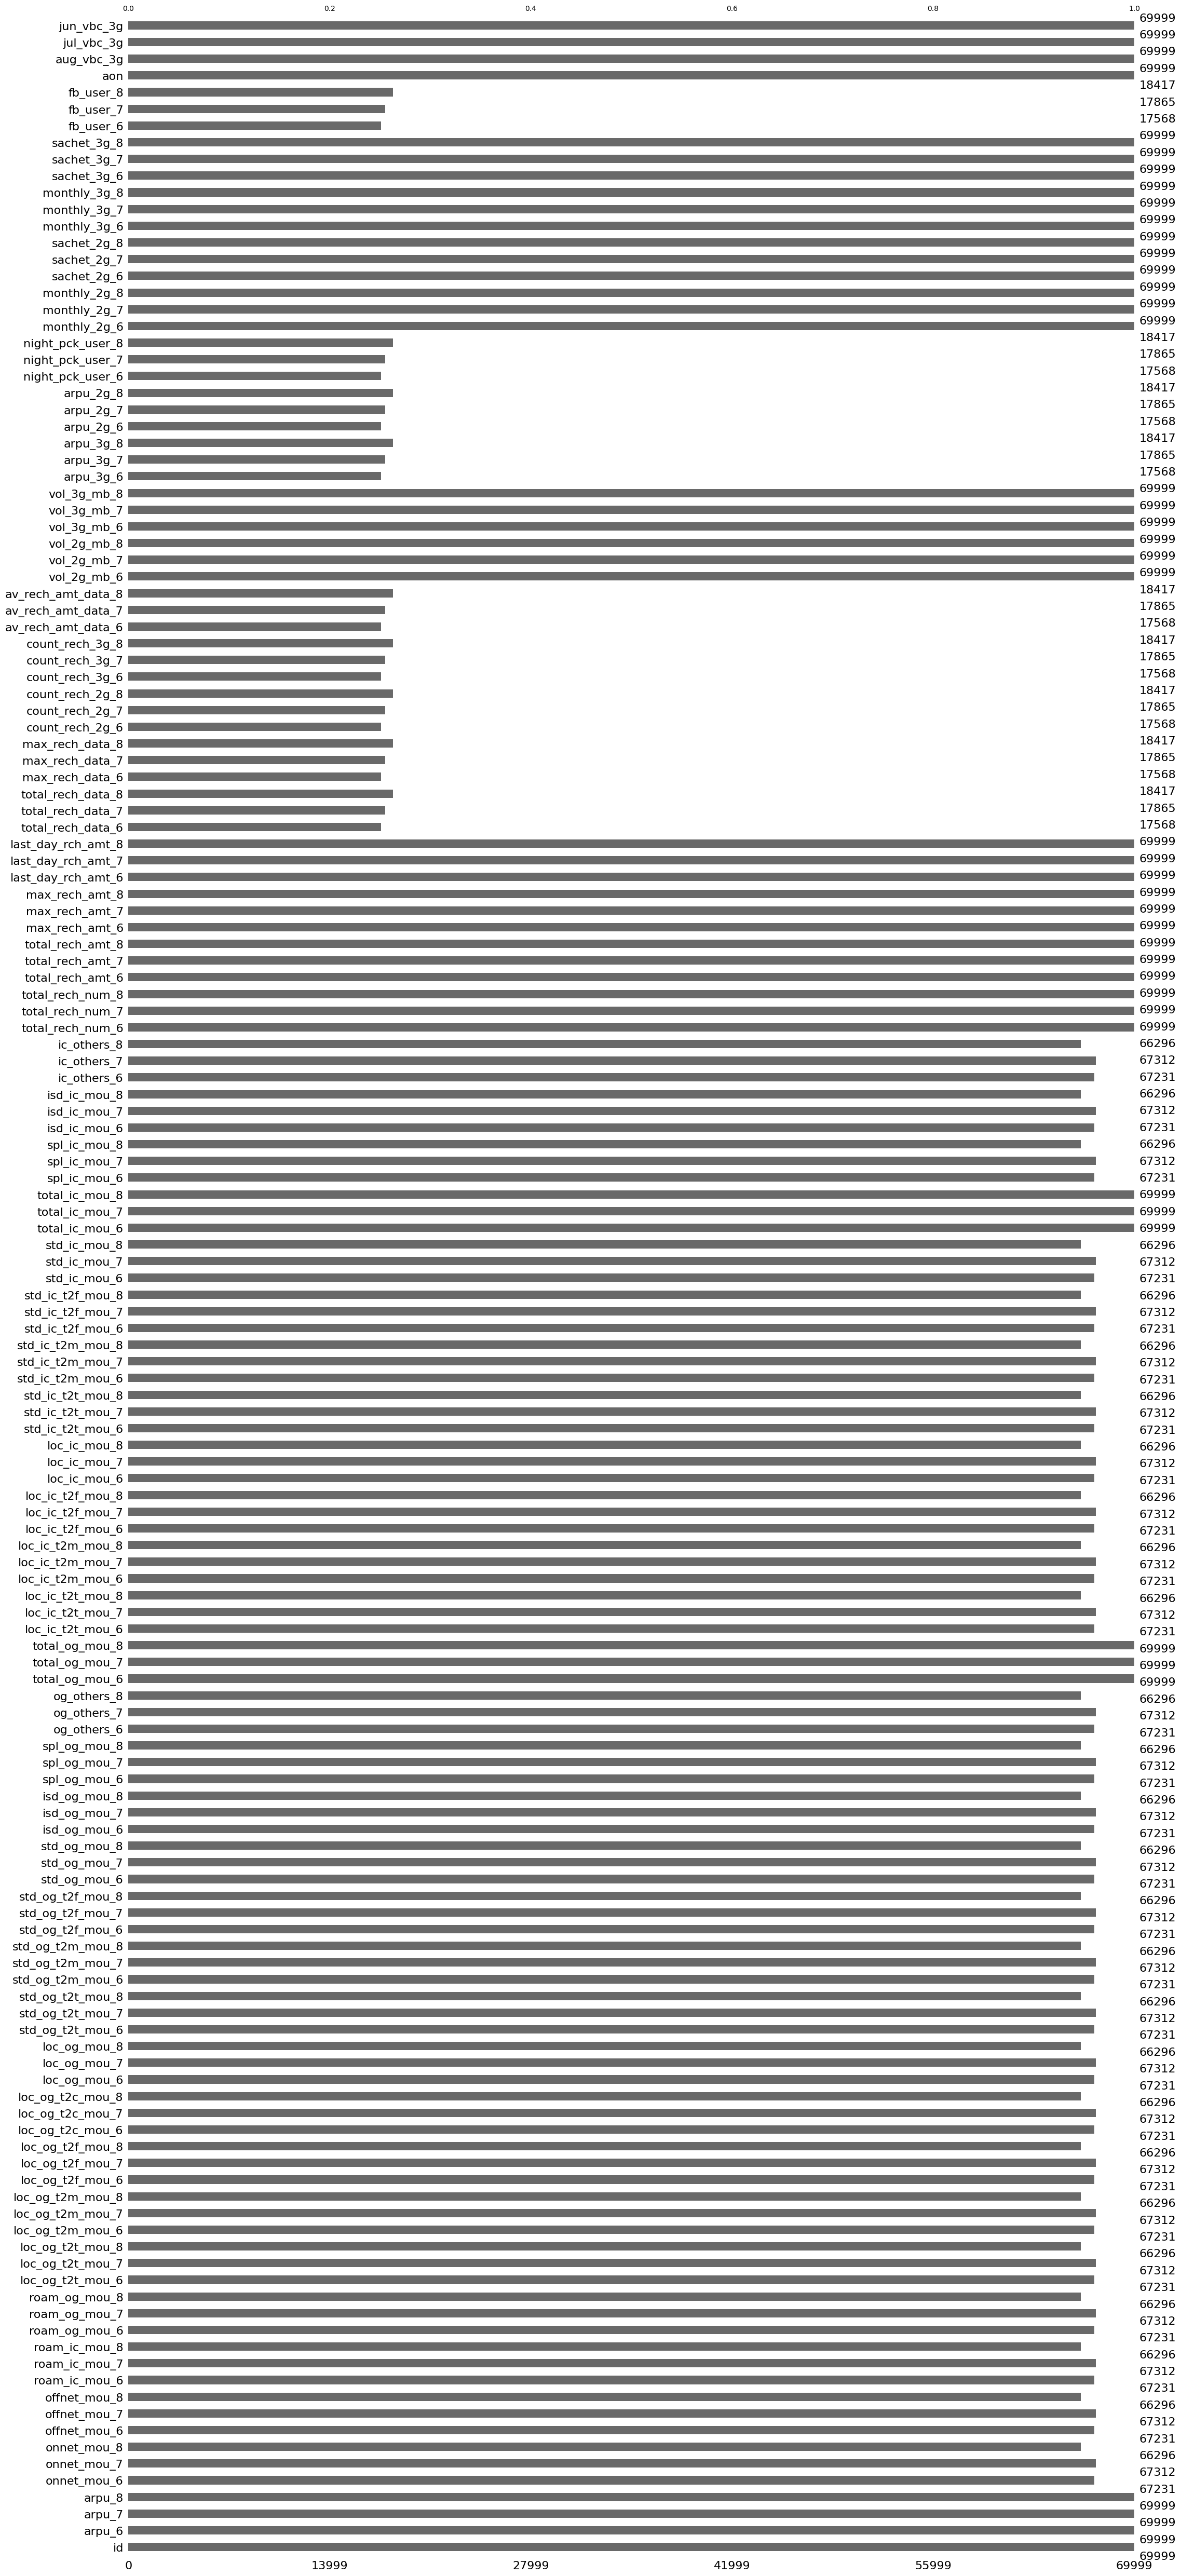

In [13]:
msno.bar(X)

In [14]:
missing_data_percent = 100*X.isnull().sum()/len(X)
missing_data_percent

id              0.000000
arpu_6          0.000000
arpu_7          0.000000
arpu_8          0.000000
onnet_mou_6     3.954342
                 ...    
fb_user_8      73.689624
aon             0.000000
aug_vbc_3g      0.000000
jul_vbc_3g      0.000000
jun_vbc_3g      0.000000
Length: 152, dtype: float64

In [15]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=125)

In [49]:
X_filtered = X[new_vars]
X_filtered.shape

(69999, 125)

In [50]:
print(X_filtered.shape)
print(y.shape)


(69999, 125)
(69999,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((55999, 125), (14000, 125), (55999,), (14000,))

In [19]:
X_train.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
21319  21319   20.463  137.121  113.202        14.64       118.61   
41502  41502  476.142  284.507  246.595       344.19       369.88   
61527  61527  157.532  205.790  197.481        14.34        28.96   
17295  17295  497.504  444.456  293.627       739.41       185.51   
40725  40725  392.907  177.291   41.404        12.06         1.28   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
21319        59.93          1.30         25.09         52.96  ...   
41502       369.58         84.48         84.76        124.29  ...   
61527        36.79        144.68        147.88        180.83  ...   
17295        66.08        481.24        673.68        534.98  ...   
40725         0.00        341.21        190.64         40.09  ...   

       monthly_3g_6  monthly_3g_7  monthly_3g_8  sachet_3g_6  sachet_3g_7  \
21319             0             0             0            0            0   
41502             0             0             0            0            0   
61527             0             0             0            0            0   
17295             0             0             0            0            0   
40725             0             0             0            0            0   

       sachet_3g_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
21319            0   452         0.0         0.0        0.00  
41502            0  2344         0.0         0.0      205.82  
61527            0   629         0.0         0.0        0.00  
17295            0   969         0.0         0.0        0.00  
40725            0  1041         0.0         0.0        0.00  

[5 rows x 125 columns]

# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

## 3.1 Handling Missing data - Training Set

In [48]:
print(X_train.shape)
print(y.shape)


(55999, 125)
(69999,)


In [20]:
# Display the data types of each column
print(X_train.dtypes)


id               int64
arpu_6         float64
arpu_7         float64
arpu_8         float64
onnet_mou_6    float64
                ...   
sachet_3g_8      int64
aon              int64
aug_vbc_3g     float64
jul_vbc_3g     float64
jun_vbc_3g     float64
Length: 125, dtype: object


In [21]:
# Select and print the data types of non-numeric columns
non_numeric_dtypes = X_train.select_dtypes(exclude=[np.number]).dtypes
print(non_numeric_dtypes)


Series([], dtype: object)


In [22]:
# Convert all columns to numeric, setting non-numeric values to NaN
X_train_filtered = X_train.apply(pd.to_numeric, errors='coerce')

In [64]:
X_train_filtered.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
21319  21319   20.463  137.121  113.202        14.64       118.61   
41502  41502  476.142  284.507  246.595       344.19       369.88   
61527  61527  157.532  205.790  197.481        14.34        28.96   
17295  17295  497.504  444.456  293.627       739.41       185.51   
40725  40725  392.907  177.291   41.404        12.06         1.28   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
21319        59.93          1.30         25.09         52.96  ...   
41502       369.58         84.48         84.76        124.29  ...   
61527        36.79        144.68        147.88        180.83  ...   
17295        66.08        481.24        673.68        534.98  ...   
40725         0.00        341.21        190.64         40.09  ...   

       monthly_3g_6  monthly_3g_7  monthly_3g_8  sachet_3g_6  sachet_3g_7  \
21319           0.0           0.0           0.0          0.0          0.0   
41502           0.0           0.0           0.0          0.0          0.0   
61527           0.0           0.0           0.0          0.0          0.0   
17295           0.0           0.0           0.0          0.0          0.0   
40725           0.0           0.0           0.0          0.0          0.0   

       sachet_3g_8     aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
21319          0.0   452.0         0.0         0.0        0.00  
41502          0.0  2344.0         0.0         0.0      205.82  
61527          0.0   629.0         0.0         0.0        0.00  
17295          0.0   969.0         0.0         0.0        0.00  
40725          0.0  1041.0         0.0         0.0        0.00  

[5 rows x 125 columns]

In [65]:
print(X_train_filtered.shape)

print(y.shape)


(55999, 125)
(69999,)


<Axes: >

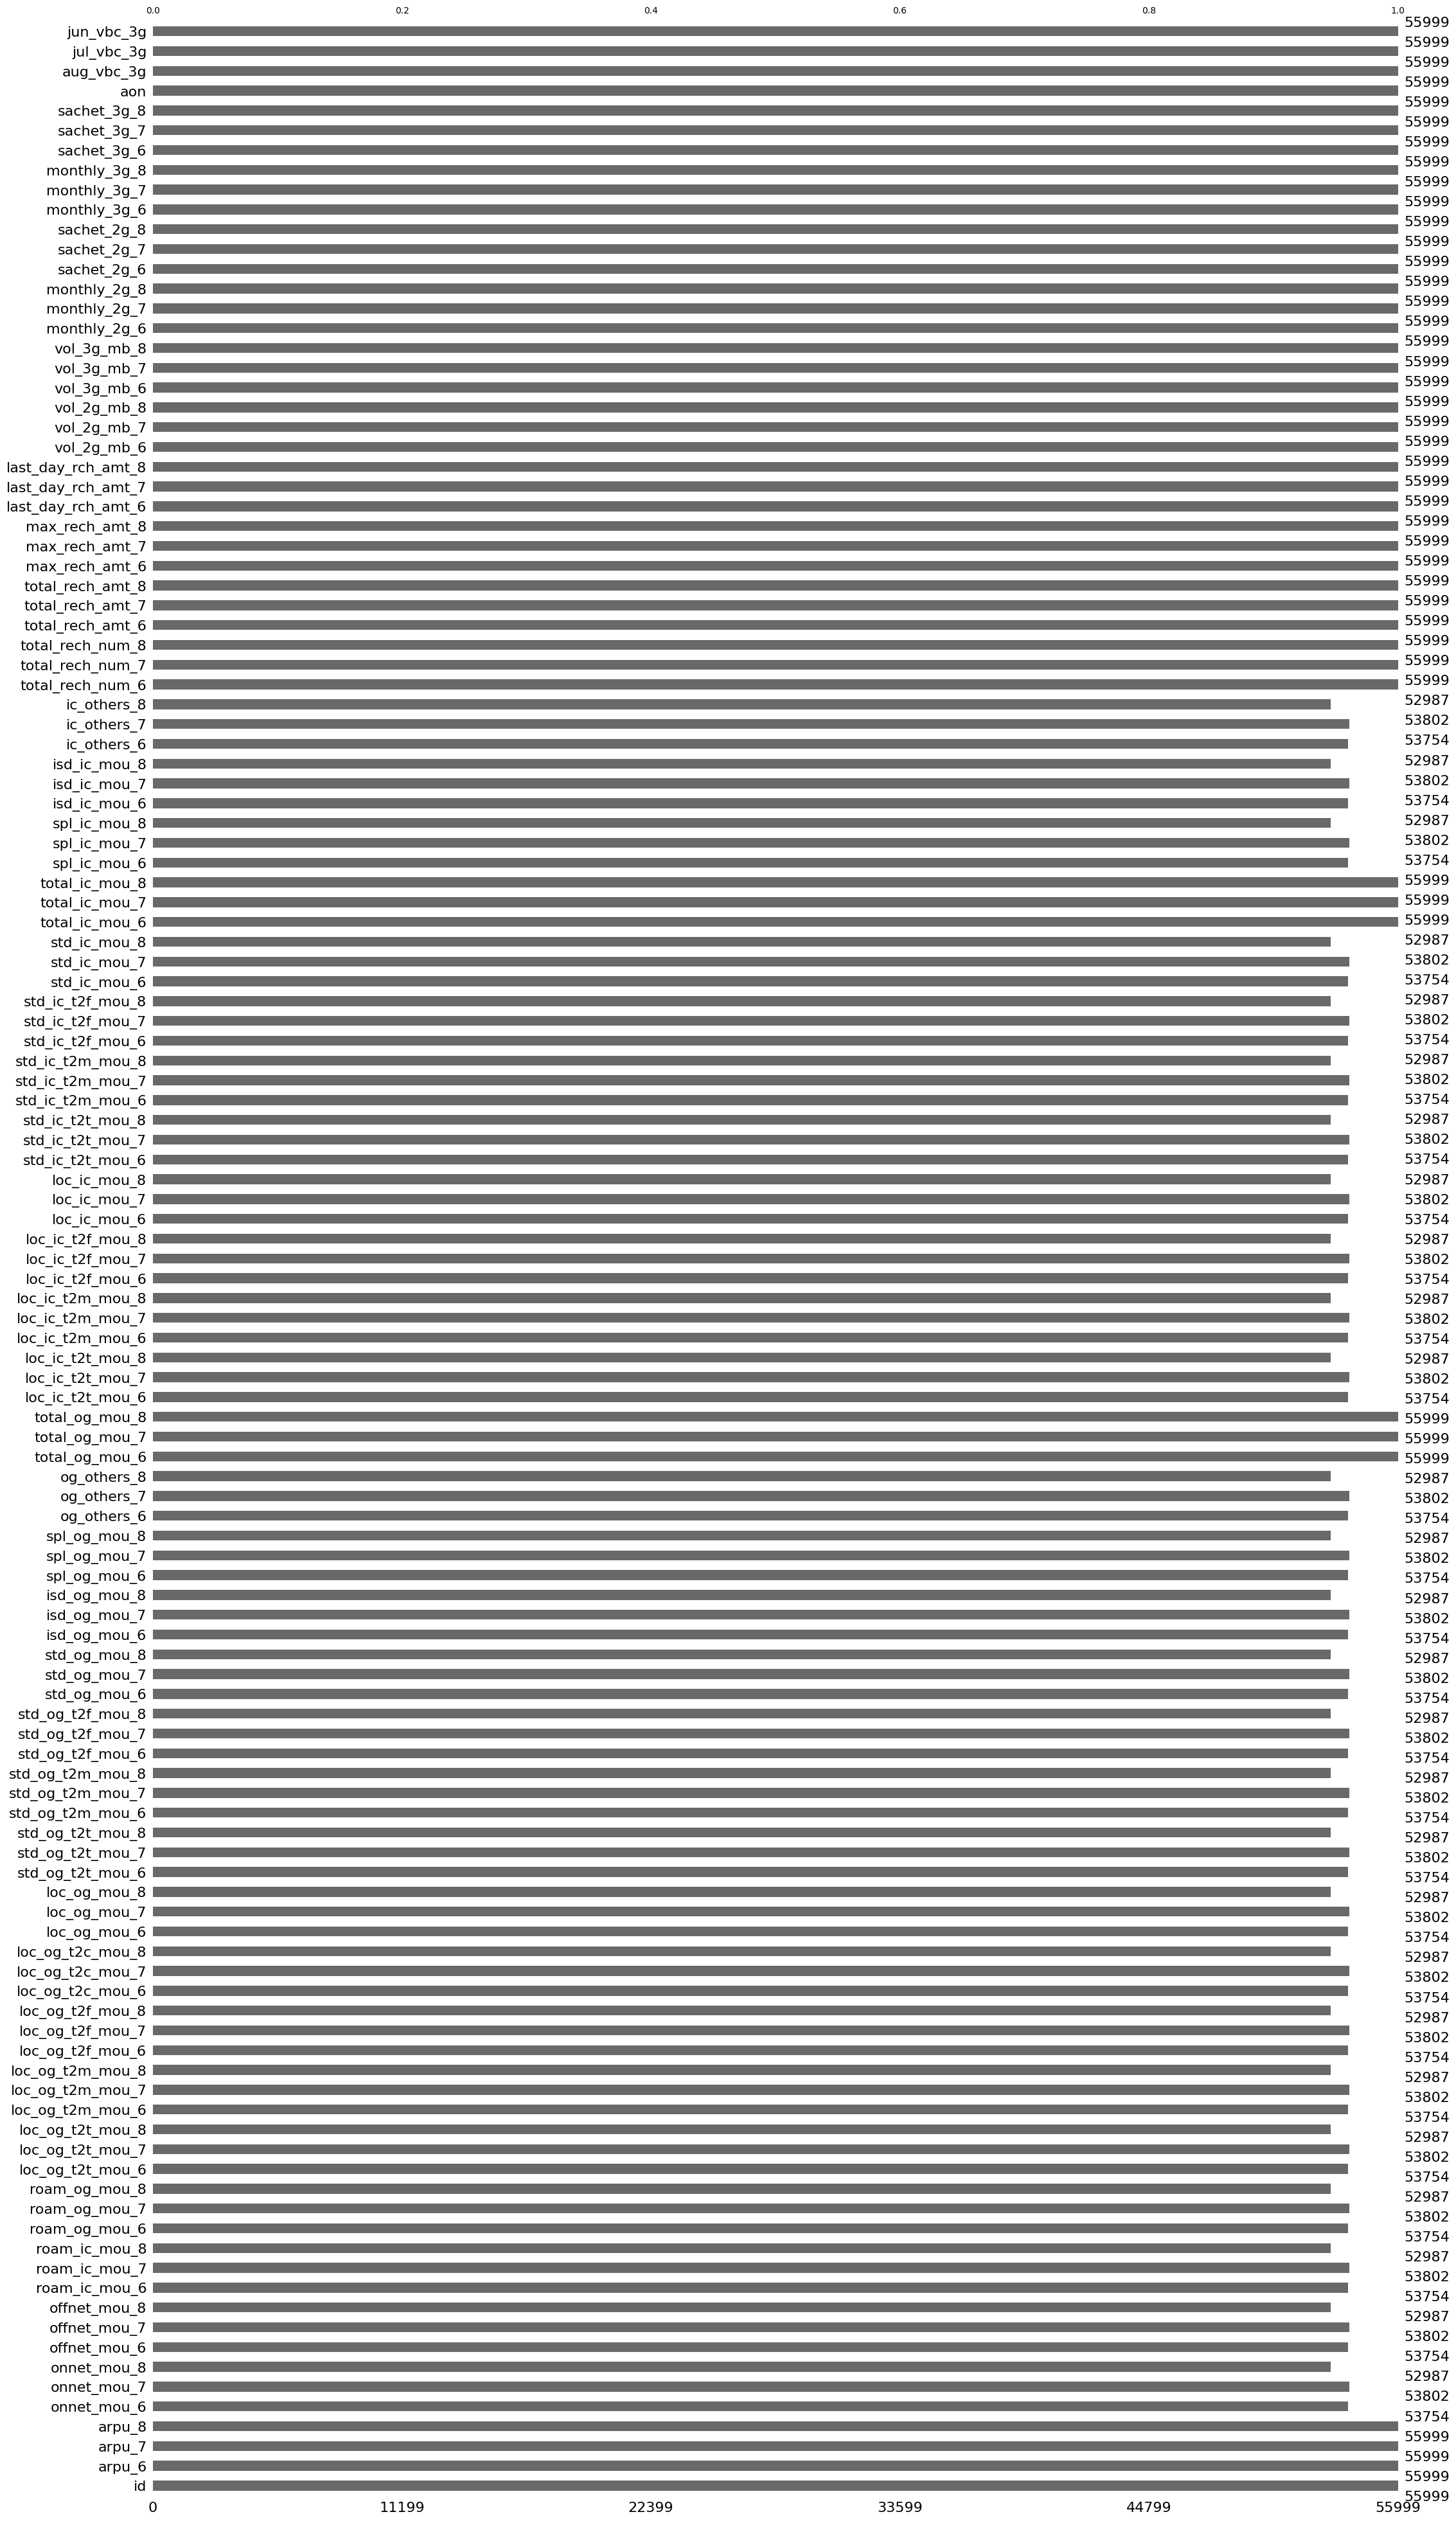

In [23]:
msno.bar(X_train)

In [24]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

In [25]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

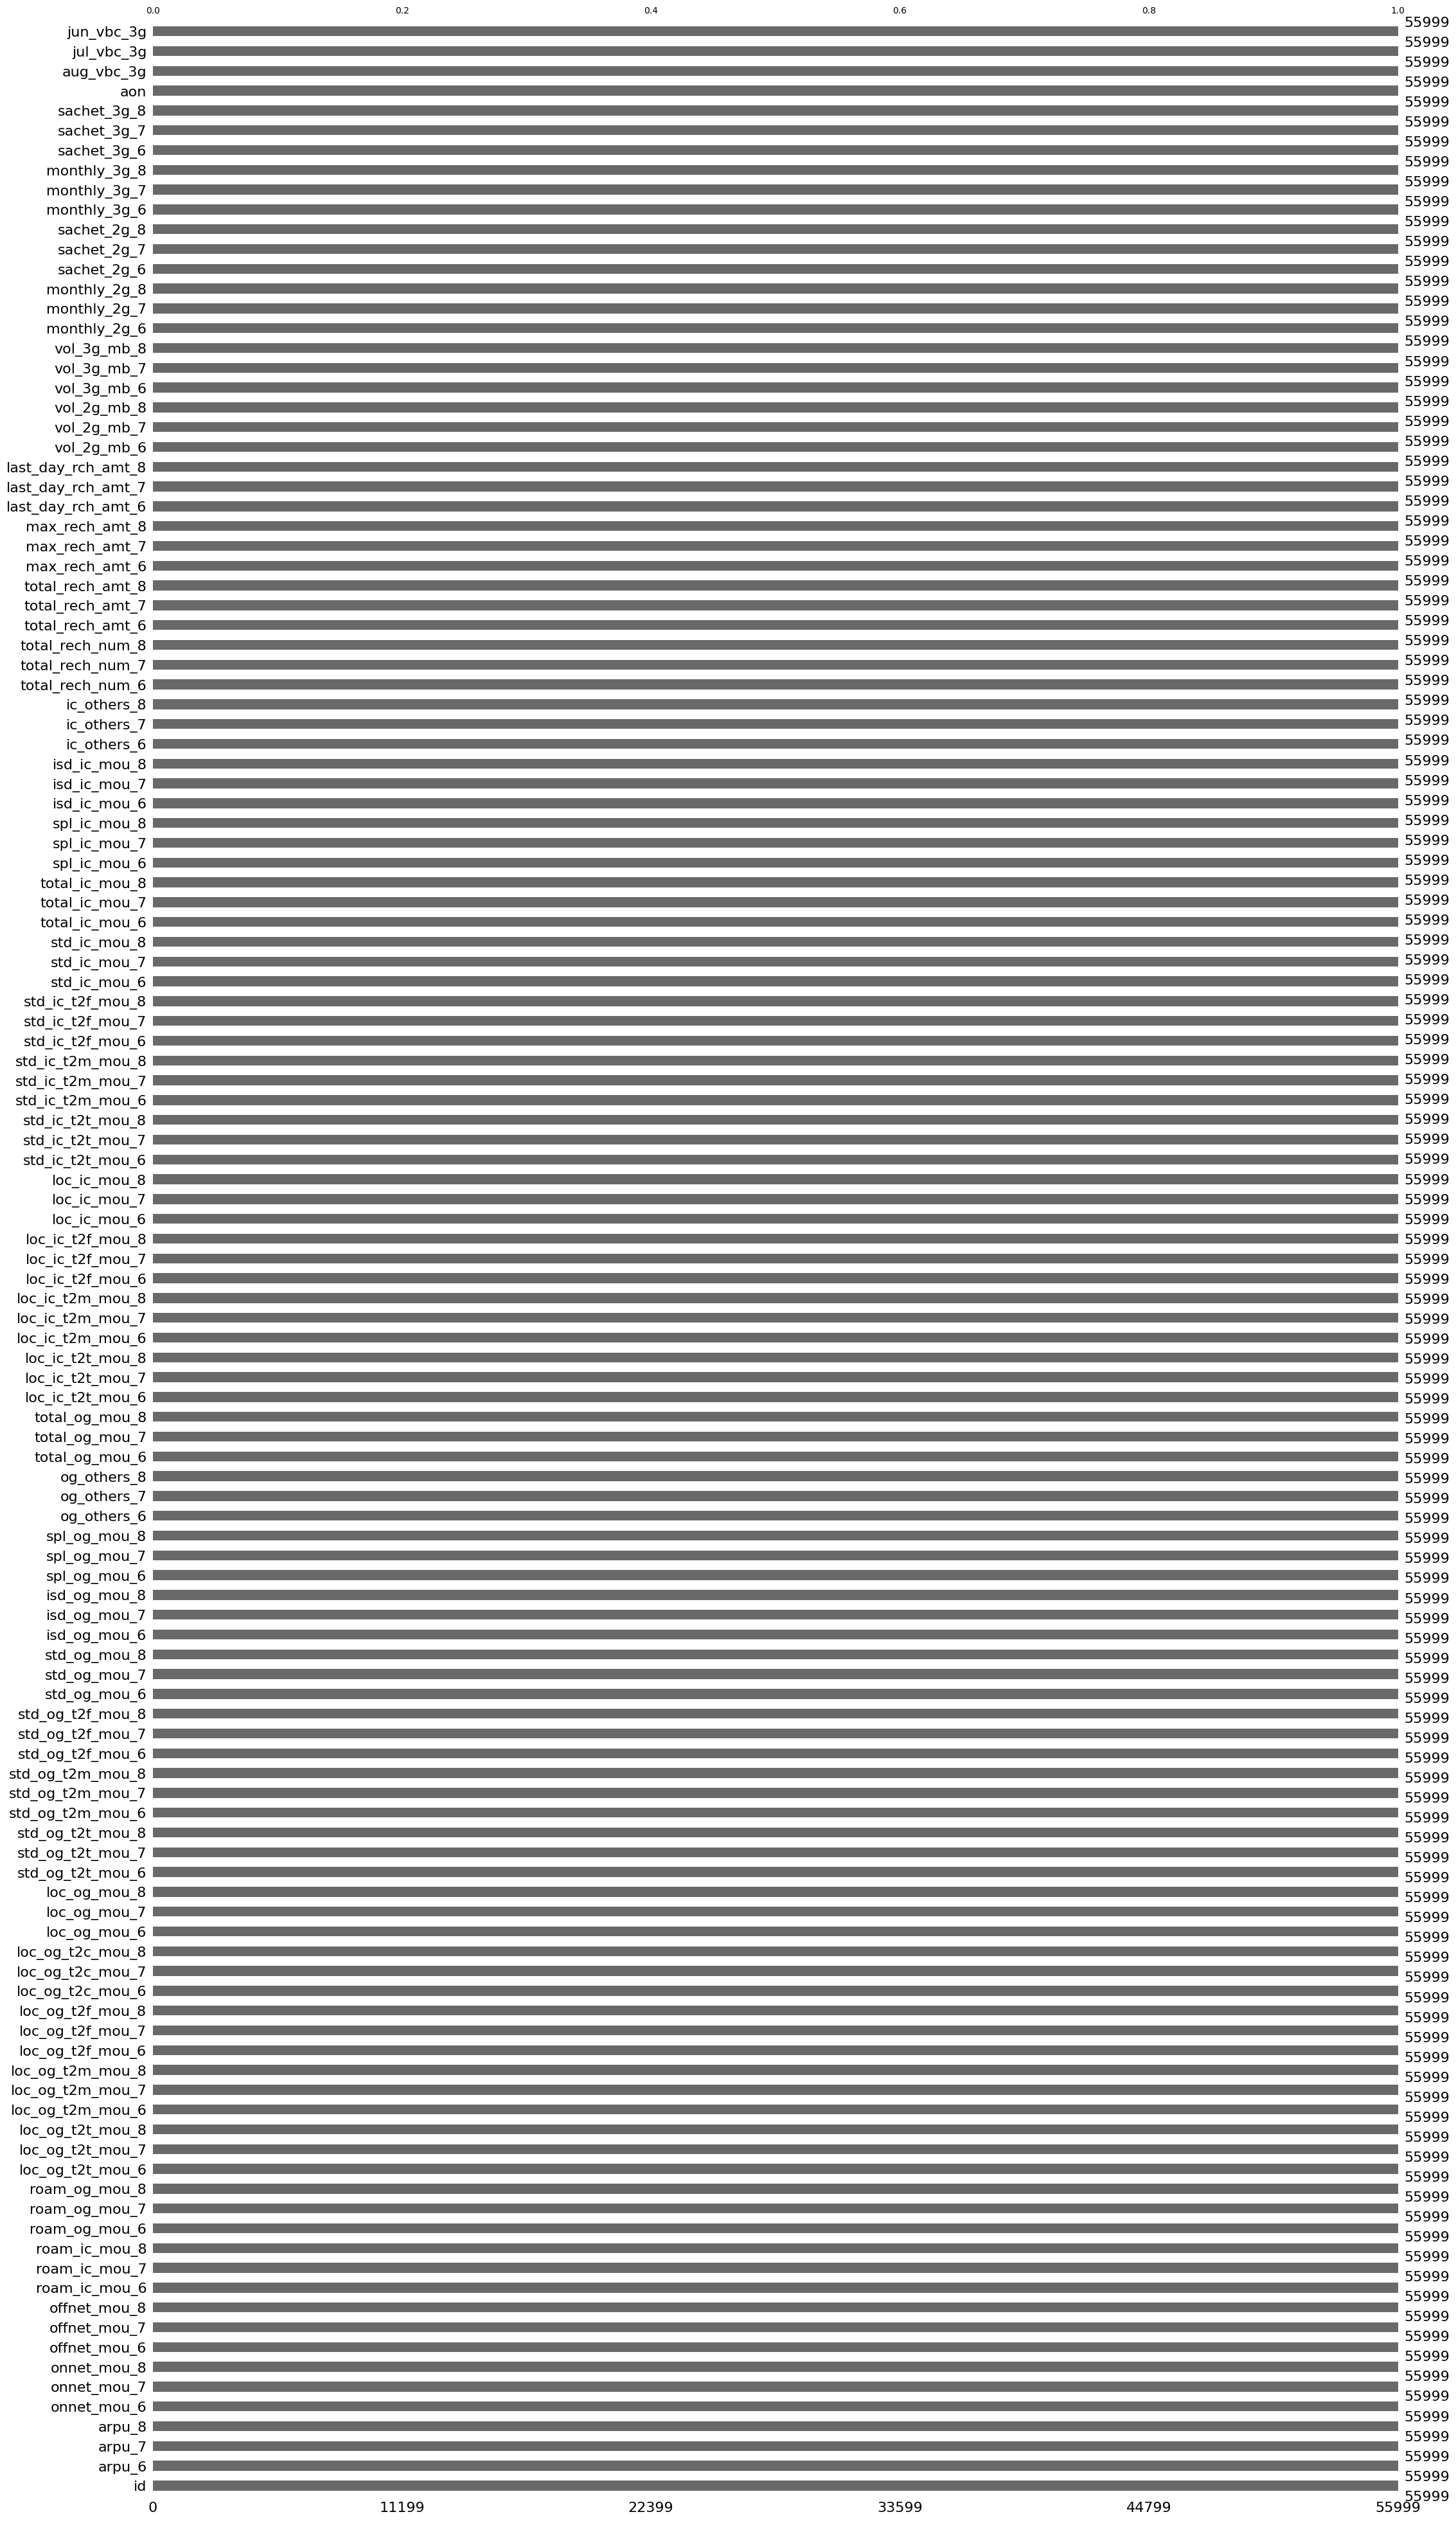

In [26]:
msno.bar(X_train_filtered)

In [46]:
print(X_train_filtered.shape)
print(y.shape)


(55999, 125)
(69999,)


In [27]:
X_train_filtered.describe()


id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean   34940.095484    282.404954    277.246232    277.626547    127.933259   
std    20212.632372    317.905894    313.392451    317.850406    295.542164   
min        0.000000  -2258.709000  -1289.715000   -945.808000      0.000000   
25%    17464.500000     93.654500     86.641500     83.487000      5.440000   
50%    34899.000000    197.638000    191.223000    191.976000     30.880000   
75%    52416.500000    370.425500    364.748000    369.734500    113.490000   
max    69998.000000  15487.684000  14624.089000  16040.503000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean     129.266362    126.245839    189.905820    188.727457    184.661484   
std      308.336639    305.418884    310.671438    318.322816    313.080011   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        4.910000      4.090000     28.610000     26.480000     23.660000   
50%       29.380000     28.010000     89.660000     85.460000     82.990000   
75%      108.785000    106.160000    222.370000    217.070000    215.520000   
max     8157.780000  10752.560000   8362.360000   6740.080000   7857.780000   

       ...  monthly_3g_6  monthly_3g_7  monthly_3g_8   sachet_3g_6  \
count  ...  55999.000000  55999.000000  55999.000000  55999.000000   
mean   ...      0.076859      0.079126      0.081751      0.074448   
std    ...      0.362567      0.389246      0.376687      0.560090   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      9.000000     16.000000     10.000000     29.000000   

        sachet_3g_7   sachet_3g_8           aon    aug_vbc_3g    jul_vbc_3g  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean       0.079894      0.084698   1222.055090     68.804807     66.364300   
std        0.612887      0.654465    952.318724    274.698184    272.027953   
min        0.000000      0.000000    180.000000      0.000000      0.000000   
25%        0.000000      0.000000    468.000000      0.000000      0.000000   
50%        0.000000      0.000000    869.000000      0.000000      0.000000   
75%        0.000000      0.000000   1817.000000      0.000000      0.000000   
max       33.000000     41.000000   4321.000000  12916.220000   9165.600000   

         jun_vbc_3g  
count  55999.000000  
mean      59.974080  
std      258.553717  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max    11166.210000  

[8 rows x 125 columns]

## 3.2 Handling Missing data - Test Set

In [28]:
# Display the data types of each column
print(X_test.dtypes)

id               int64
arpu_6         float64
arpu_7         float64
arpu_8         float64
onnet_mou_6    float64
                ...   
sachet_3g_8      int64
aon              int64
aug_vbc_3g     float64
jul_vbc_3g     float64
jun_vbc_3g     float64
Length: 125, dtype: object


In [29]:
# Select and print the data types of non-numeric columns
non_numeric_dtypes = X_test.select_dtypes(exclude=[np.number]).dtypes
print(non_numeric_dtypes)


Series([], dtype: object)


In [30]:
# Convert all columns to numeric, setting non-numeric values to NaN
X_test_filtered = X_test.apply(pd.to_numeric, errors='coerce')

<Axes: >

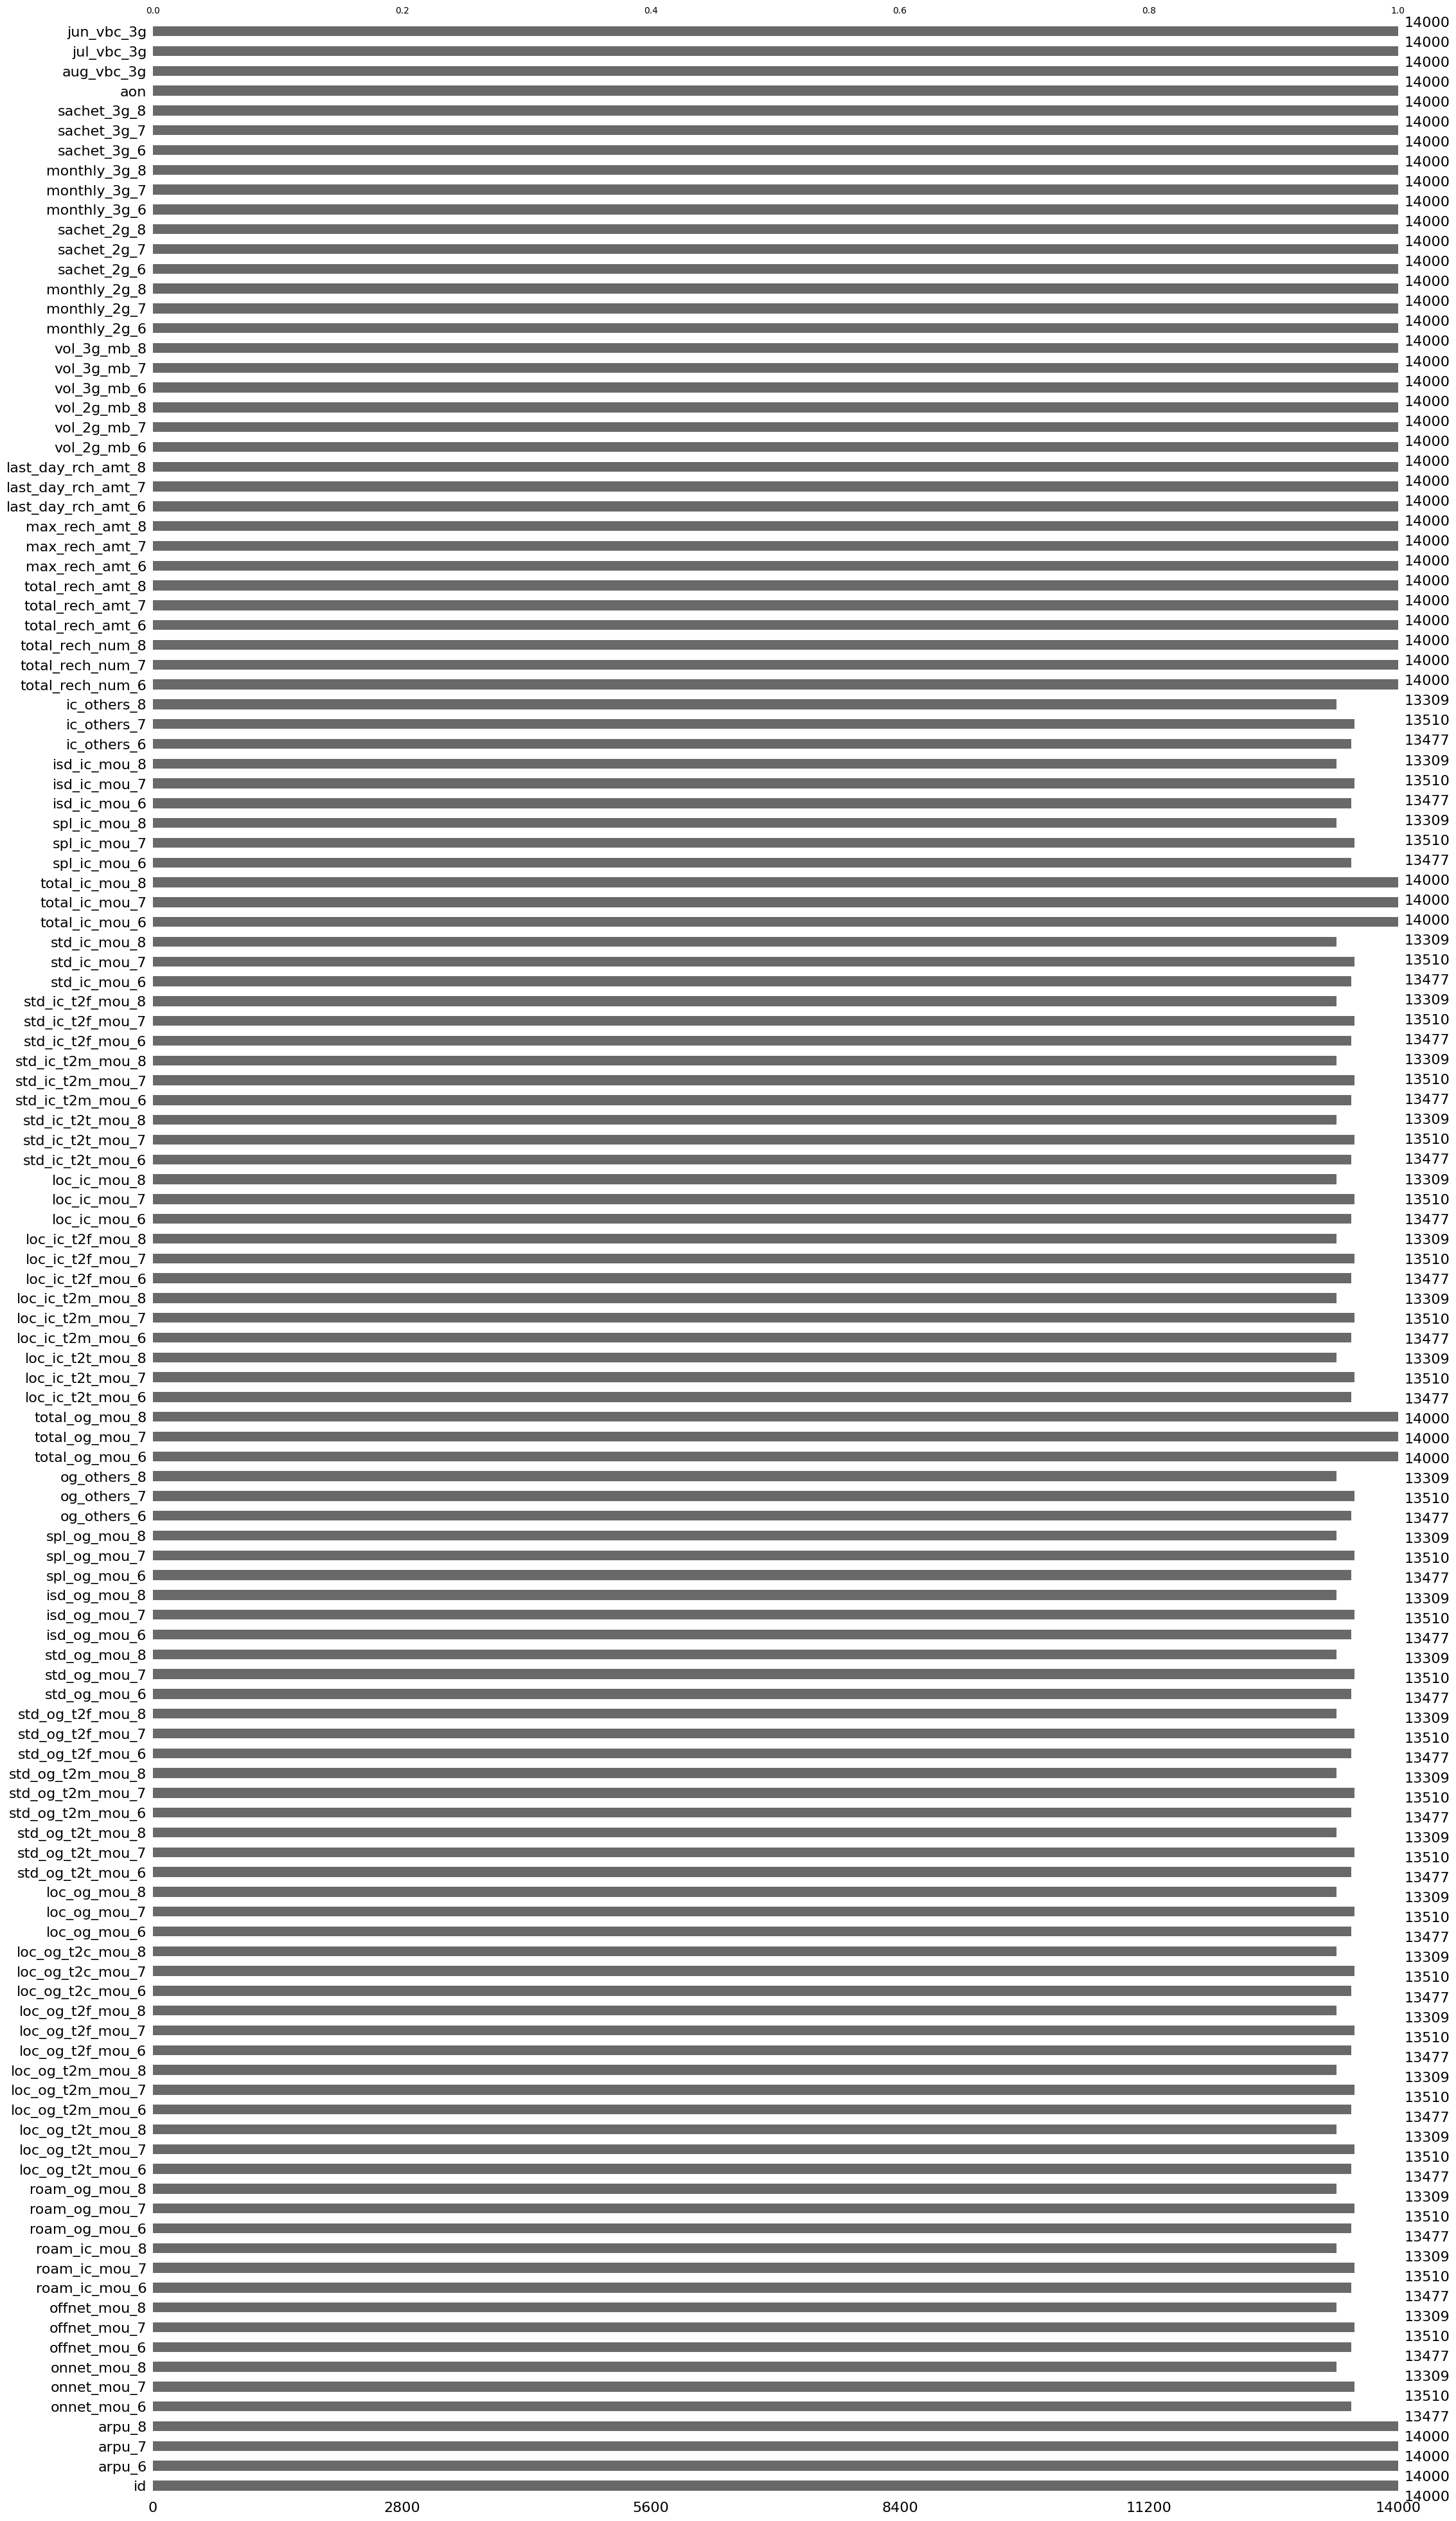

In [31]:
msno.bar(X_test)

In [32]:
missing_data_percent = X_test_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

In [33]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_test_filtered[impute_cols] = imp.fit_transform(X_test_filtered[impute_cols])

<Axes: >

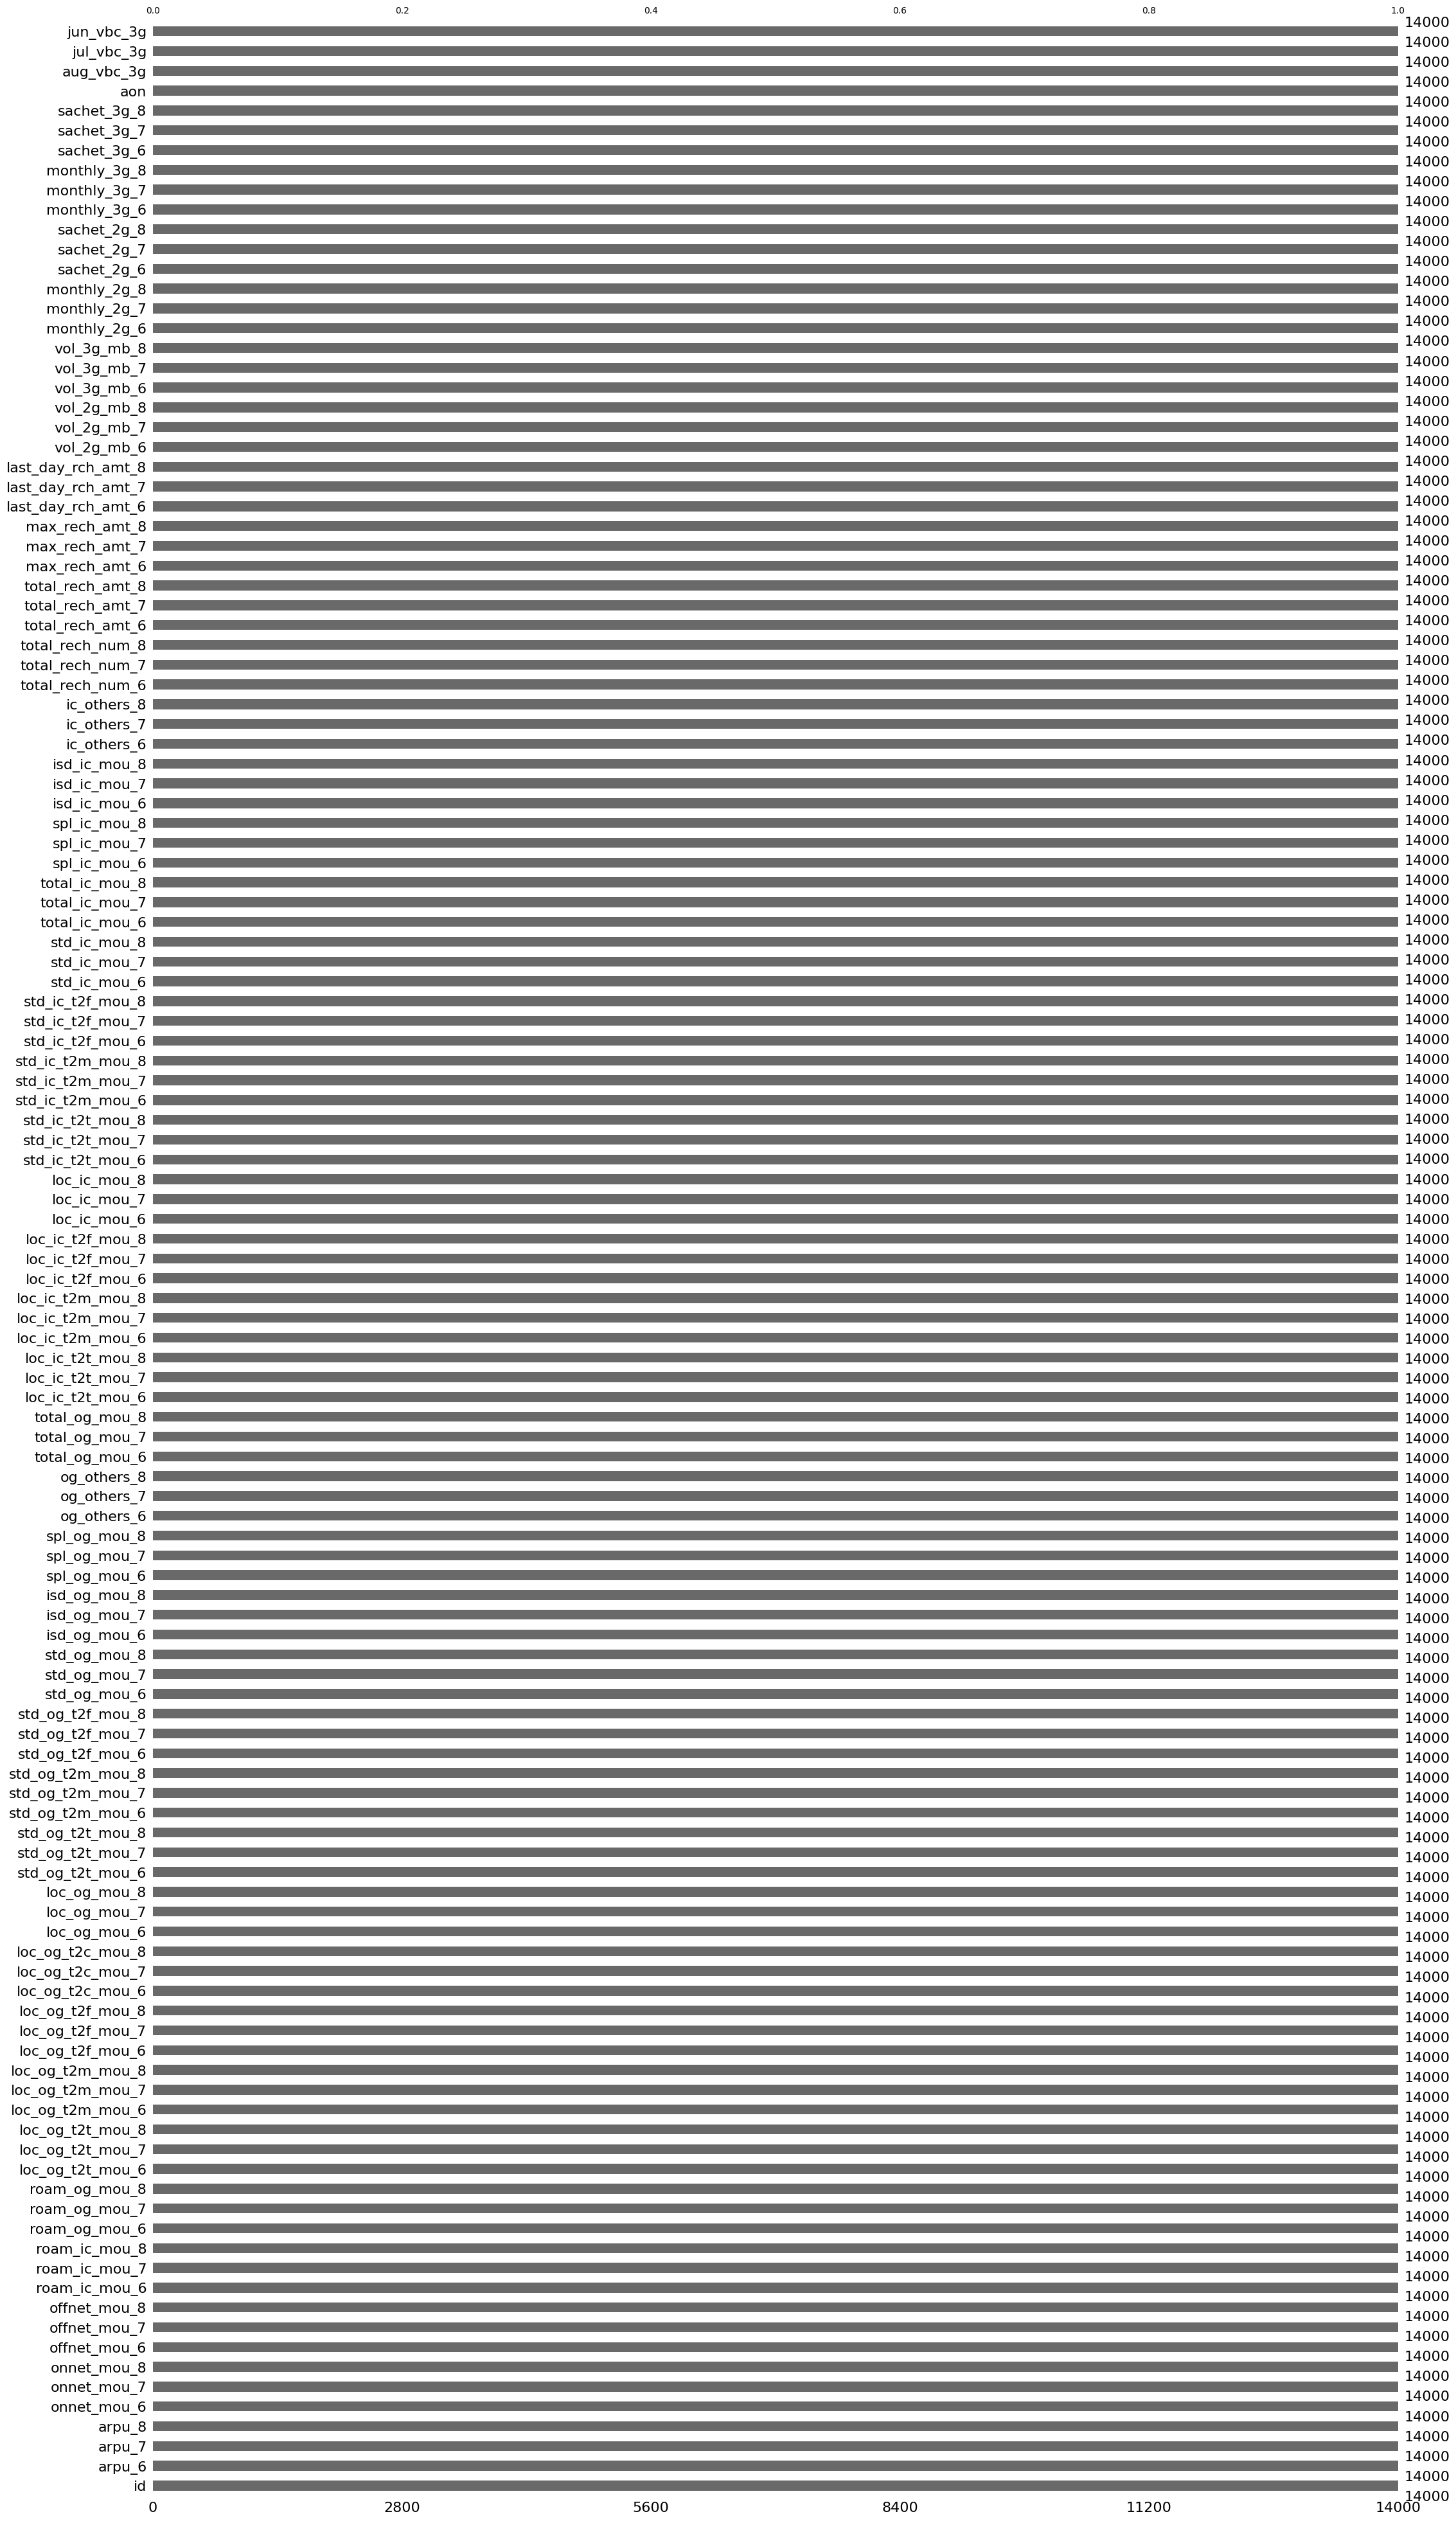

In [34]:
msno.bar(X_test_filtered)

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

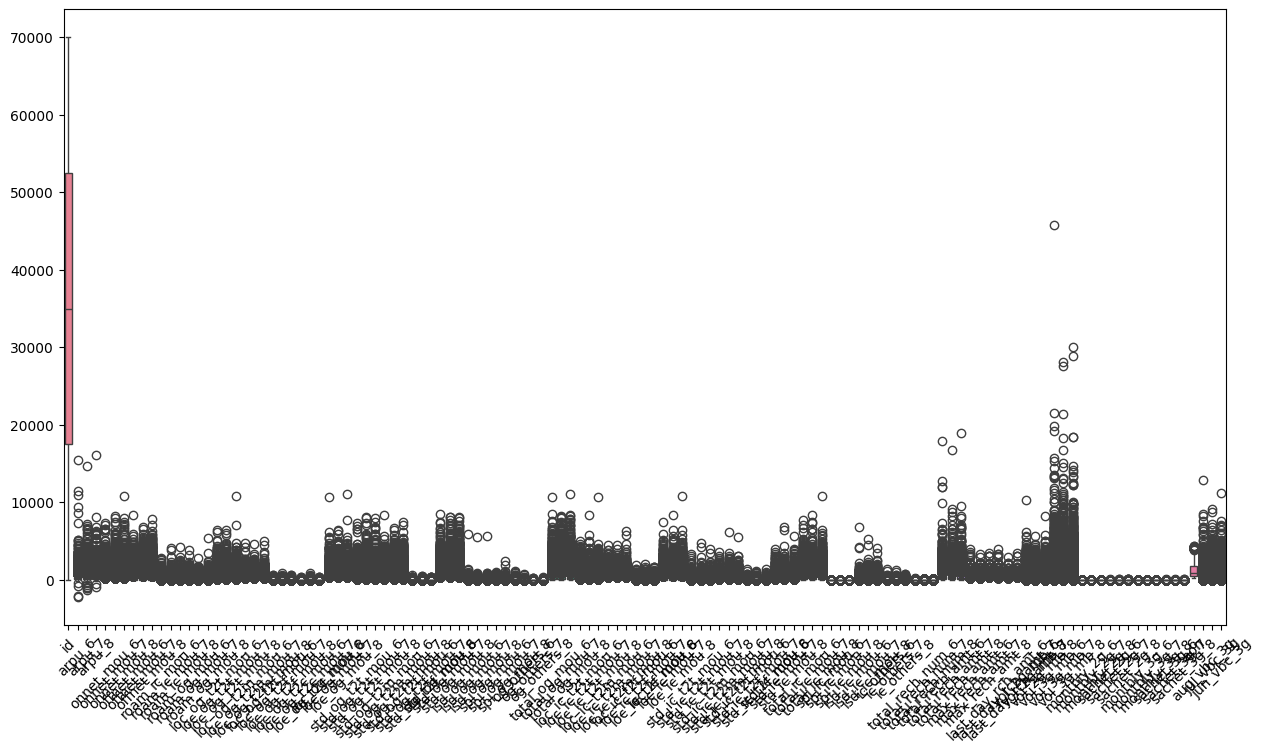

In [35]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [36]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [66]:
X_train_filtered.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
21319  21319   20.463  137.121  113.202        14.64       118.61   
41502  41502  476.142  284.507  246.595       344.19       369.88   
61527  61527  157.532  205.790  197.481        14.34        28.96   
17295  17295  497.504  444.456  293.627       739.41       185.51   
40725  40725  392.907  177.291   41.404        12.06         1.28   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
21319        59.93          1.30         25.09         52.96  ...   
41502       369.58         84.48         84.76        124.29  ...   
61527        36.79        144.68        147.88        180.83  ...   
17295        66.08        481.24        673.68        534.98  ...   
40725         0.00        341.21        190.64         40.09  ...   

       monthly_3g_6  monthly_3g_7  monthly_3g_8  sachet_3g_6  sachet_3g_7  \
21319           0.0           0.0           0.0          0.0          0.0   
41502           0.0           0.0           0.0          0.0          0.0   
61527           0.0           0.0           0.0          0.0          0.0   
17295           0.0           0.0           0.0          0.0          0.0   
40725           0.0           0.0           0.0          0.0          0.0   

       sachet_3g_8     aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
21319          0.0   452.0         0.0         0.0        0.00  
41502          0.0  2344.0         0.0         0.0      205.82  
61527          0.0   629.0         0.0         0.0        0.00  
17295          0.0   969.0         0.0         0.0        0.00  
40725          0.0  1041.0         0.0         0.0        0.00  

[5 rows x 125 columns]

<Axes: >

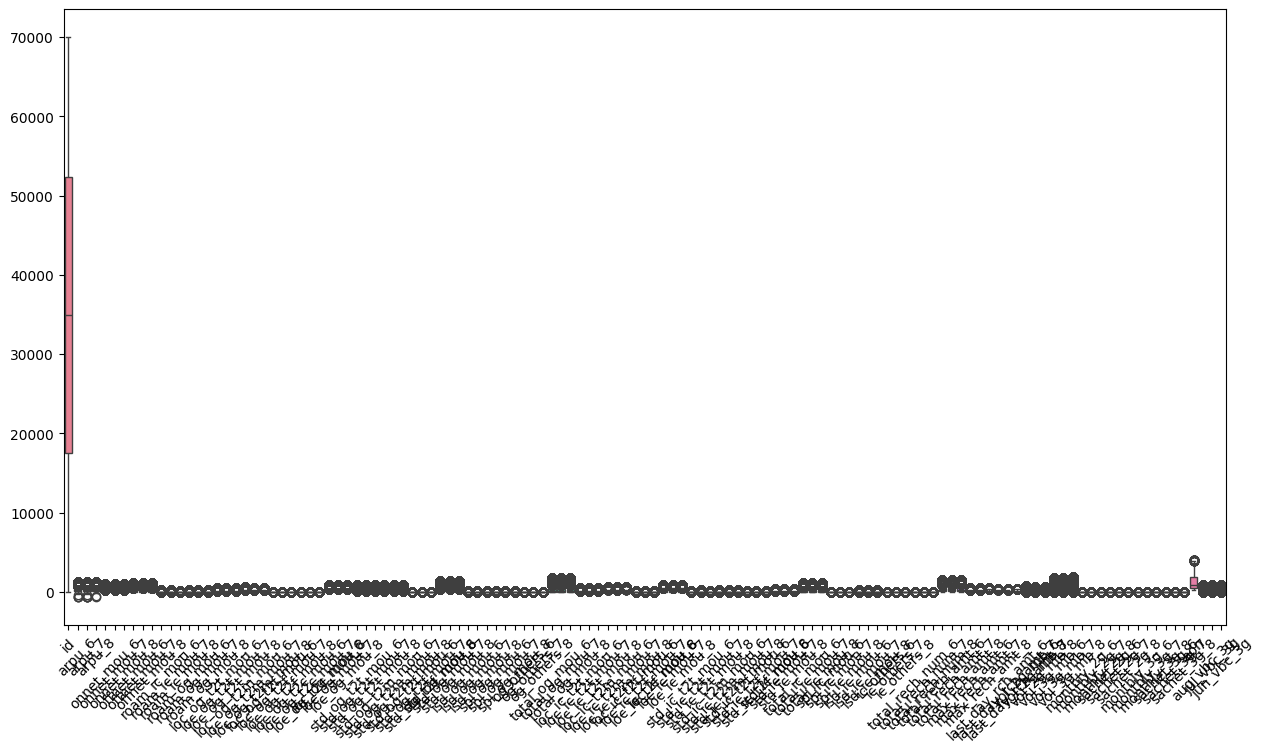

In [37]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [67]:
X_train_filtered1.head() 

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
21319  21319   20.463  137.121  113.202        14.64       118.61   
41502  41502  476.142  284.507  246.595       344.19       369.88   
61527  61527  157.532  205.790  197.481        14.34        28.96   
17295  17295  497.504  444.456  293.627       739.41       185.51   
40725  40725  392.907  177.291   41.404        12.06         1.28   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
21319        59.93          1.30         25.09         52.96  ...   
41502       369.58         84.48         84.76        124.29  ...   
61527        36.79        144.68        147.88        180.83  ...   
17295        66.08        481.24        673.68        534.98  ...   
40725         0.00        341.21        190.64         40.09  ...   

       monthly_3g_6  monthly_3g_7  monthly_3g_8  sachet_3g_6  sachet_3g_7  \
21319           0.0           0.0           0.0          0.0          0.0   
41502           0.0           0.0           0.0          0.0          0.0   
61527           0.0           0.0           0.0          0.0          0.0   
17295           0.0           0.0           0.0          0.0          0.0   
40725           0.0           0.0           0.0          0.0          0.0   

       sachet_3g_8     aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
21319          0.0   452.0         0.0         0.0        0.00  
41502          0.0  2344.0         0.0         0.0      205.82  
61527          0.0   629.0         0.0         0.0        0.00  
17295          0.0   969.0         0.0         0.0        0.00  
40725          0.0  1041.0         0.0         0.0        0.00  

[5 rows x 125 columns]

In [38]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

<Axes: >

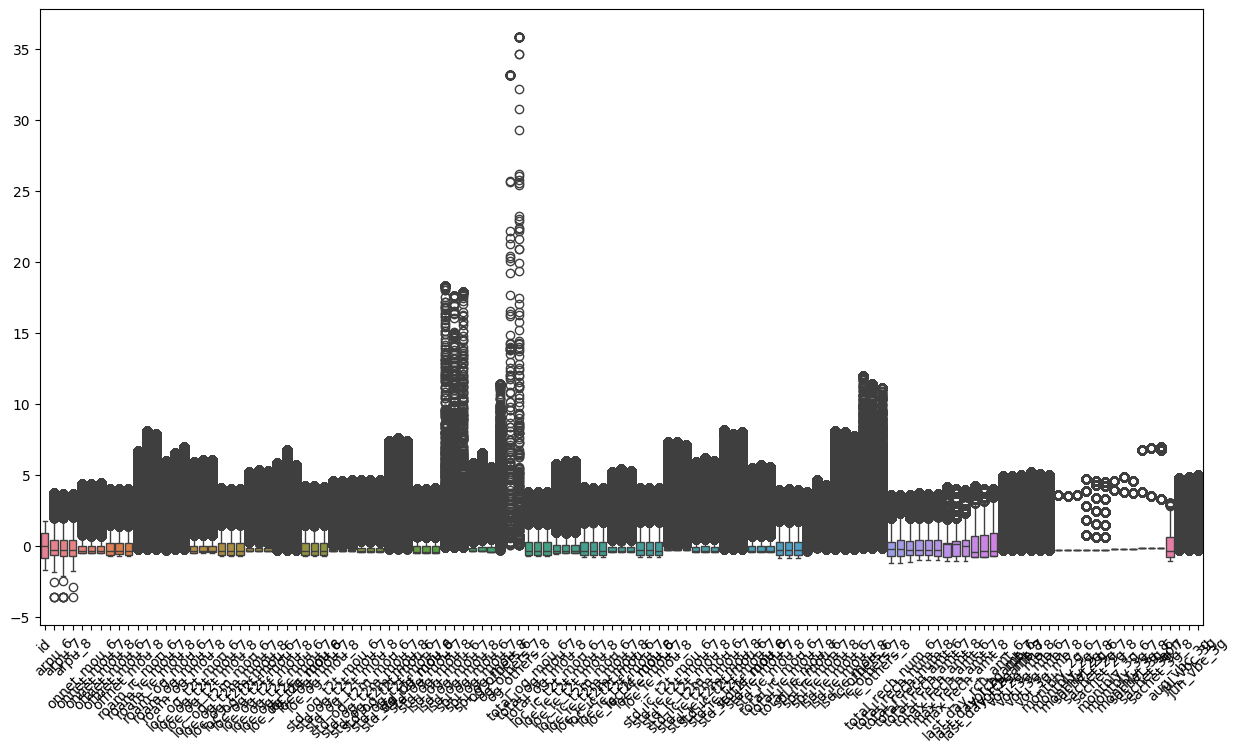

In [39]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

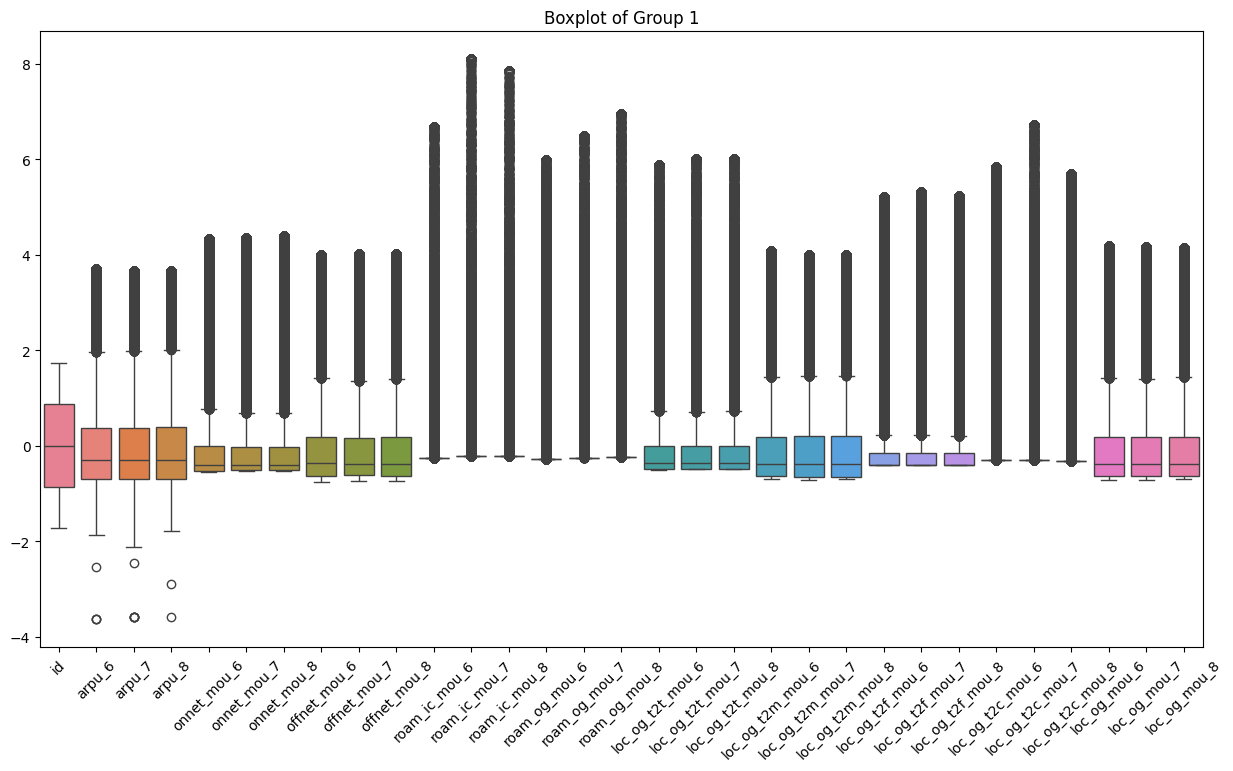

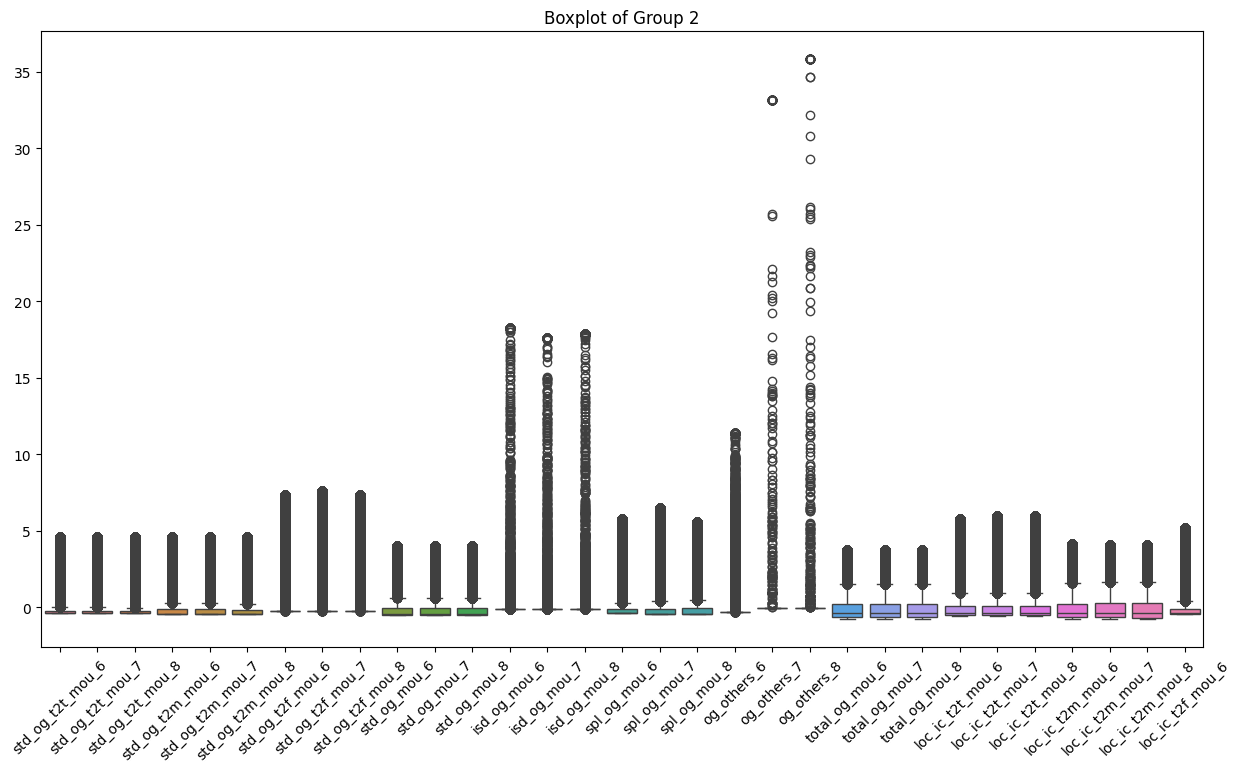

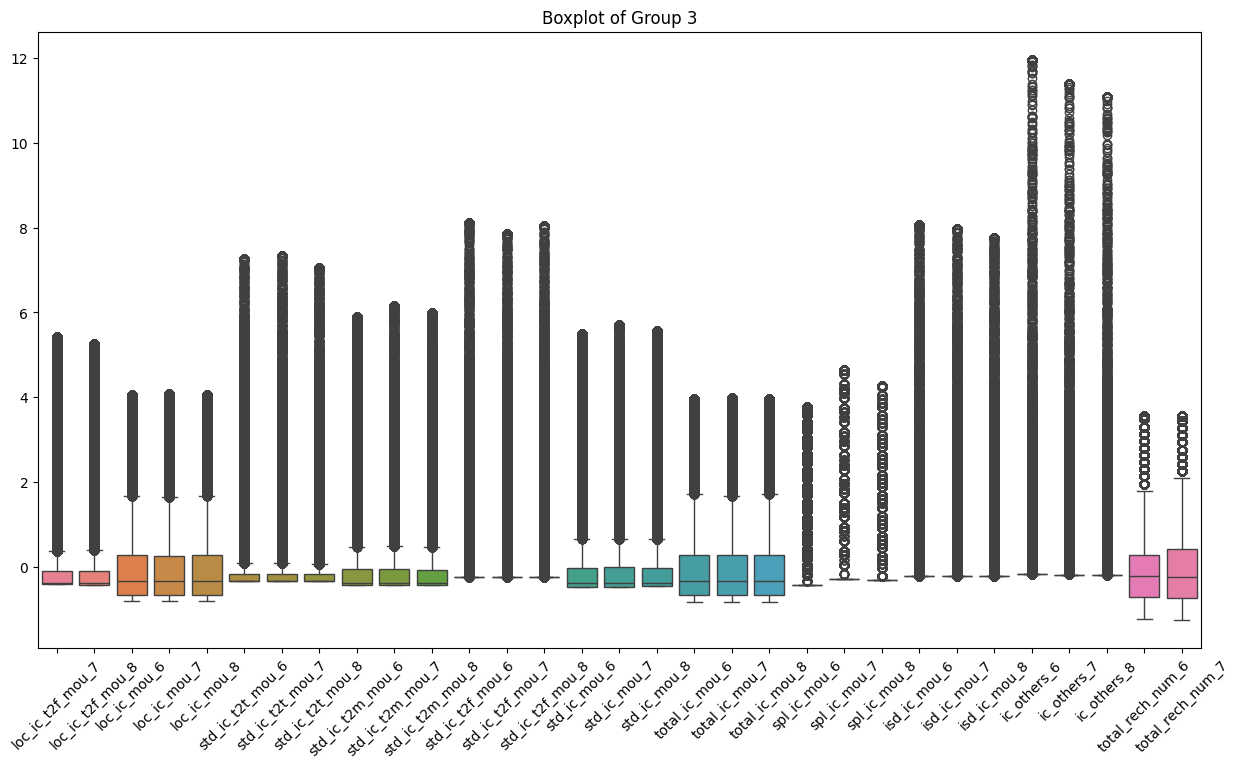

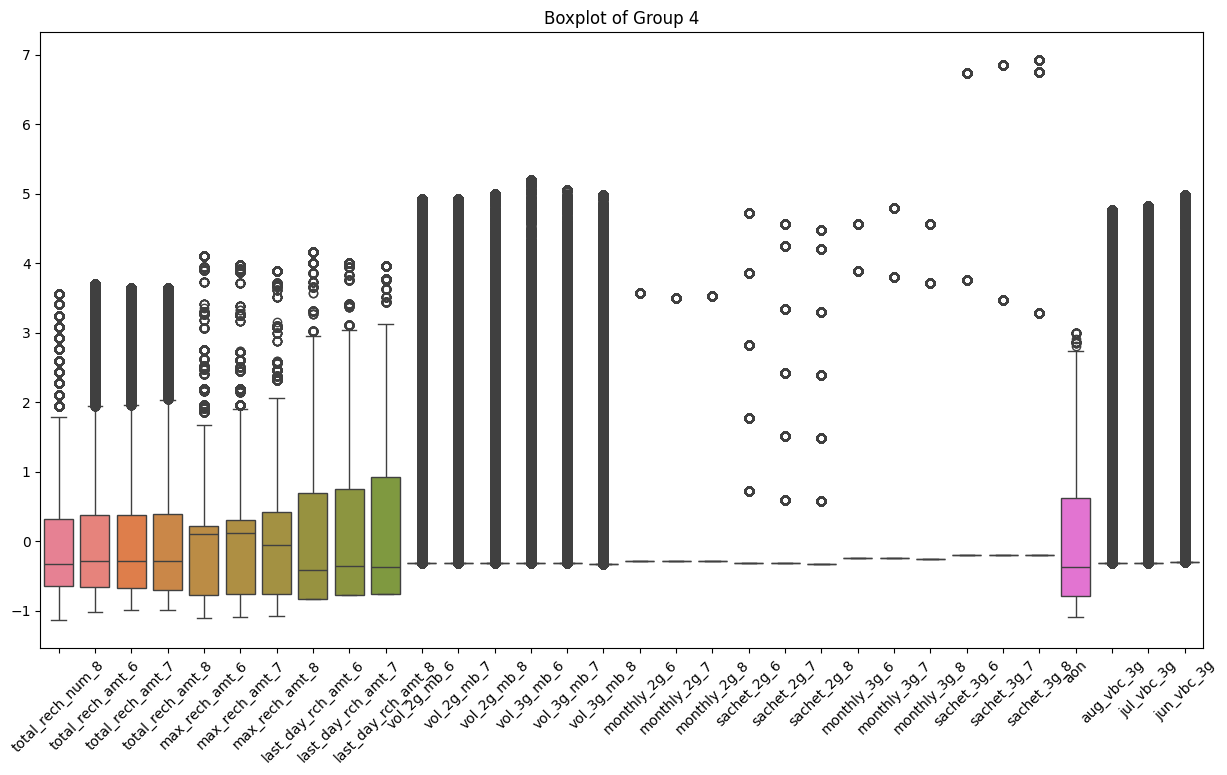

In [40]:
# Convert X_train_filtered2 to a DataFrame with column names from new_vars
X_train_filtered2_df = pd.DataFrame(X_train_filtered2, columns=new_vars)

# Define the number of groups
num_groups = 4
columns_per_group = len(new_vars) // num_groups

# Create separate boxplots for each group of columns
for i in range(num_groups):
    # Select the subset of columns for this group
    start = i * columns_per_group
    end = (i + 1) * columns_per_group if i != num_groups - 1 else len(new_vars)
    group_columns = new_vars[start:end]
    
    # Create the boxplot for the current group by selecting only the relevant columns
    plt.figure(figsize=(15, 8))
    plt.xticks(rotation=45)
    sns.boxplot(data=X_train_filtered2_df[group_columns])
    plt.title(f"Boxplot of Group {i + 1}")
    plt.show()

<Axes: >

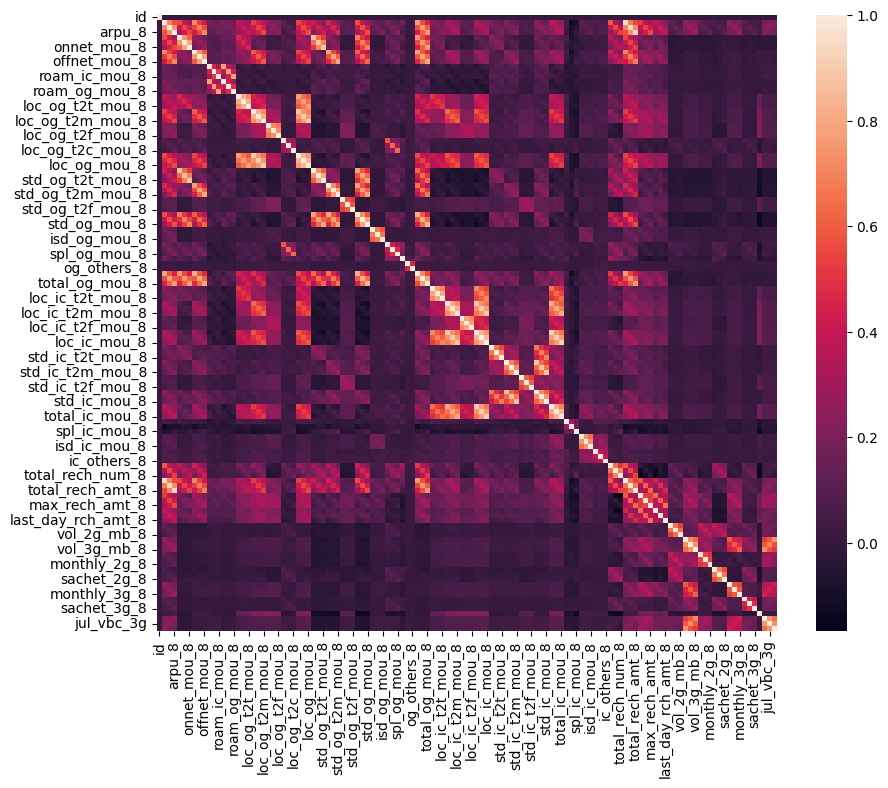

In [40]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

<Axes: xlabel='churn_probability', ylabel='Count'>

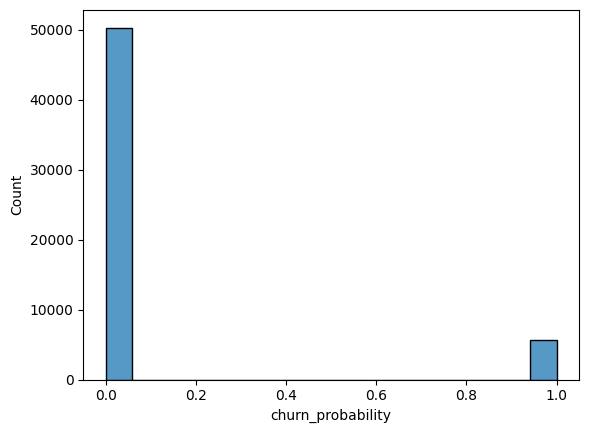

In [41]:
#Distribution for the churn probability
sns.histplot(y_train)

### Sekecting Features with RFE

In [68]:
print(X_train_filtered.shape)
print(y.shape)


(55999, 125)
(69999,)


In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

logreg = LogisticRegression()
rfe = RFE(estimator=logreg, n_features_to_select=13)  # specify n_features_to_select as a keyword argument
rfe = rfe.fit(X_train_filtered2, y_train)
print(rfe.support_)  # Print the boolean results


[False False False False False False False False False False False False
 False False False False False False  True False False  True False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
  True False False  True False  True  True False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False  True False False
  True False False  True False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False]


In [56]:


# converting to data frame, in order to extract columns
X_train_filtered2_df = pd.DataFrame(X_train_filtered2)


In [62]:
X_train_filtered2_df.head()

0         1         2         3         4         5         6    \
0 -0.673896 -0.976885 -0.507409 -0.592763 -0.480527  0.014280 -0.249360   
1  0.324647  0.775495  0.059992 -0.085629  1.101722  1.180366  1.213934   
2  1.315373 -0.449766 -0.243050 -0.272351 -0.481967 -0.401764 -0.358711   
3 -0.872981  0.857646  0.675757  0.093177  2.999267  0.324748 -0.220297   
4  0.286205  0.455403 -0.352764 -0.865725 -0.492914 -0.530221 -0.532567   

        7         8         9    ...       115       116       117       118  \
0 -0.743886 -0.627165 -0.505228  ... -0.247006 -0.244295 -0.253182 -0.200058   
1 -0.392782 -0.379383 -0.203892  ... -0.247006 -0.244295 -0.253182 -0.200058   
2 -0.138677 -0.117275  0.034964  ... -0.247006 -0.244295 -0.253182 -0.200058   
3  1.281947  2.066131  1.531084  ... -0.247006 -0.244295 -0.253182 -0.200058   
4  0.690879  0.060288 -0.559598  ... -0.247006 -0.244295 -0.253182 -0.200058   

        119      120       121       122       123       124  
0 -0.196217 -0.19755 -0.808729 -0.320154 -0.309982 -0.301048  
1 -0.196217 -0.19755  1.178477 -0.320154 -0.309982  1.000725  
2 -0.196217 -0.19755 -0.622823 -0.320154 -0.309982 -0.301048  
3 -0.196217 -0.19755 -0.265714 -0.320154 -0.309982 -0.301048  
4 -0.196217 -0.19755 -0.190091 -0.320154 -0.309982 -0.301048  

[5 rows x 125 columns]

In [57]:
# Replace with the actual feature names list if X_train_filtered2 is a NumPy array
feature_names = X_train_filtered2_df.columns  # Or use the feature names list
selected_features = [feature_names[i] for i in range(len(feature_names)) if rfe.support_[i]]
print(selected_features)


[18, 21, 30, 57, 60, 63, 65, 66, 84, 93, 96, 99, 102]


In [59]:
# Extract selected feature names using RFE support mask
selected_features = X_train_filtered2_df.columns[rfe.support_]
print(list(selected_features))  # Print as a list for readability

[18, 21, 30, 57, 60, 63, 65, 66, 84, 93, 96, 99, 102]


In [60]:
X_train_filtered2_df.head()

0         1         2         3         4         5         6    \
0 -0.673896 -0.976885 -0.507409 -0.592763 -0.480527  0.014280 -0.249360   
1  0.324647  0.775495  0.059992 -0.085629  1.101722  1.180366  1.213934   
2  1.315373 -0.449766 -0.243050 -0.272351 -0.481967 -0.401764 -0.358711   
3 -0.872981  0.857646  0.675757  0.093177  2.999267  0.324748 -0.220297   
4  0.286205  0.455403 -0.352764 -0.865725 -0.492914 -0.530221 -0.532567   

        7         8         9    ...       115       116       117       118  \
0 -0.743886 -0.627165 -0.505228  ... -0.247006 -0.244295 -0.253182 -0.200058   
1 -0.392782 -0.379383 -0.203892  ... -0.247006 -0.244295 -0.253182 -0.200058   
2 -0.138677 -0.117275  0.034964  ... -0.247006 -0.244295 -0.253182 -0.200058   
3  1.281947  2.066131  1.531084  ... -0.247006 -0.244295 -0.253182 -0.200058   
4  0.690879  0.060288 -0.559598  ... -0.247006 -0.244295 -0.253182 -0.200058   

        119      120       121       122       123       124  
0 -0.196217 -0.19755 -0.808729 -0.320154 -0.309982 -0.301048  
1 -0.196217 -0.19755  1.178477 -0.320154 -0.309982  1.000725  
2 -0.196217 -0.19755 -0.622823 -0.320154 -0.309982 -0.301048  
3 -0.196217 -0.19755 -0.265714 -0.320154 -0.309982 -0.301048  
4 -0.196217 -0.19755 -0.190091 -0.320154 -0.309982 -0.301048  

[5 rows x 125 columns]

In [61]:
X_train_filtered2.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

#### Same operation needs to be done for Unseen data as well @ Michel...........

In [42]:
#Segregating the train data for high value customers
## This needs to be done before Scaling ....
X_train_filtered.columns

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=125)

In [43]:
X_train_filtered.shape

(55999, 125)

In [44]:
X_train_filtered.shape

(55999, 125)

In [45]:
y_train.value_counts()

0    50302
1     5697
Name: churn_probability, dtype: int64

In [46]:
y_test.value_counts()

0    12565
1     1435
Name: churn_probability, dtype: int64

<Axes: xlabel='churn_probability', ylabel='Count'>

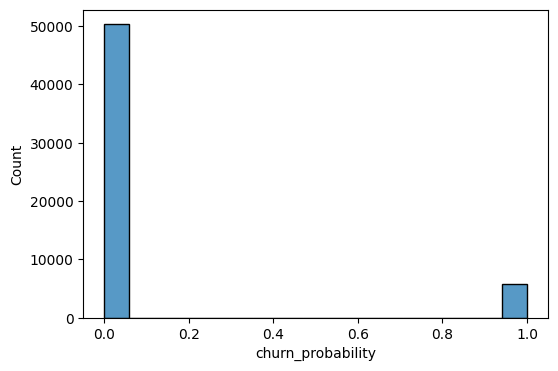

In [47]:
#Distribution for the churn probability
plt.figure(figsize=(6, 4))
sns.histplot(y_train)

In [50]:
from imblearn.over_sampling import SMOTE

In [52]:
smt = SMOTE(random_state=2)
X_train_smote, y_train_smote = smt.fit_resample(X_train_filtered2, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)


(100604, 125)
(100604,)
